# Initialization Schemes for Input Convex Neural Network

As input convex neural networks (ICNN) are notoriously difficult to train {cite}`richter-powell:21`, {cite}`bunne:22` propose to use closed-form solutions between Gaussian approximations to derive relevant parameter initializations for ICNNs: given two measures $\mu$ and $\nu$, one can initialize ICNN parameters so that they are (initially) meaningful in the context of OT, namely that its gradient is able to approximately map source measure $\mu$ into a target measure $\nu$. These initializations rely on closed-form solutions available for Gaussian measures {cite}`gelbrich:90`.

In this notebook, we introduce the *identity* and *Gaussian approximation*-based initialization schemes, and illustrate how they can be used within the `OTT` library when using {class}`~ott.solvers.nn.icnn.ICNN`-based  potentials with the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` solver.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from torch.utils.data import DataLoader, IterableDataset

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.solvers.nn import icnn, neuraldual

## Helper Functions

Let us define some helper functions which we use for the subsequent analysis.

In [3]:
def get_optimizer(optimizer, lr, b1, b2, eps):
    """Returns a flax optimizer object based on `config`."""

    if optimizer == "Adam":
        optimizer = optax.adam(learning_rate=lr, b1=b1, b2=b2, eps=eps)
    elif optimizer == "SGD":
        optimizer = optax.sgd(learning_rate=lr, momentum=None, nesterov=False)
    else:
        raise NotImplementedError(f"Optimizer {optimizer} not supported yet!")

    return optimizer

## Setup Training and Validation Datasets

To test the ICNN initialization methods, we choose the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` of the `OTT` library as an example. Here, we aim at computing the map between two toy datasets representing both, source and target distribution. For more details on the execution of the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual`, we refer the reader to {doc}`neural_dual` notebook.

In this tutorial, the user can choose between the datasets `simple` (data clustered in one center), `circle` (two-dimensional Gaussians arranged on a circle), `square_five` (two-dimensional Gaussians on a square with one Gaussian in the center), and `square_four` (two-dimensional Gaussians in the corners of a rectangle).

In [4]:
class ToyDataset(IterableDataset):
    def __init__(self, name):
        self.name = name

    def __iter__(self):
        return self.create_sample_generators()

    def create_sample_generators(self, scale=5.0, variance=0.5):
        # given name of dataset, select centers
        if self.name == "simple":
            centers = np.array([0, 0])

        elif self.name == "circle":
            centers = np.array(
                [
                    (1, 0),
                    (-1, 0),
                    (0, 1),
                    (0, -1),
                    (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
                    (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
                    (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
                    (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
                ]
            )

        elif self.name == "square_five":
            centers = np.array([[0, 0], [1, 1], [-1, 1], [-1, -1], [1, -1]])

        elif self.name == "square_four":
            centers = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])

        else:
            raise NotImplementedError()

        # create generator which randomly picks center and adds noise
        centers = scale * centers
        while True:
            center = centers[np.random.choice(len(centers))]
            point = center + variance**2 * np.random.randn(2)

            yield point


def load_toy_data(
    name_source: str,
    name_target: str,
    batch_size: int = 1024,
    valid_batch_size: int = 1024,
):
    dataloaders = (
        iter(DataLoader(ToyDataset(name_source), batch_size=batch_size)),
        iter(DataLoader(ToyDataset(name_target), batch_size=batch_size)),
        iter(DataLoader(ToyDataset(name_source), batch_size=valid_batch_size)),
        iter(DataLoader(ToyDataset(name_target), batch_size=valid_batch_size)),
    )
    input_dim = 2
    return dataloaders, input_dim

## Experimental Setup 

In order to solve the neural dual, we need to define our dataloaders. The only requirement is that the corresponding source and target train and validation datasets are *iterators*.

In [5]:
(dataloader_source, dataloader_target, _, _), input_dim = load_toy_data(
    "simple", "circle"
)

To visualize the initialization schemes, let's sample data from the source and target distribution.

In [6]:
data_source = next(dataloader_source).numpy()
data_target = next(dataloader_target).numpy()

In [7]:
# initialize optimizers
optimizer_f = get_optimizer("Adam", lr=0.0001, b1=0.5, b2=0.9, eps=1e-8)
optimizer_g = get_optimizer("Adam", lr=0.0001, b1=0.5, b2=0.9, eps=1e-8)

### Identity Initialization Method

Next, we define the architectures parameterizing the dual potentials $f$ and $g$. These need to be parameterized by ICNNs. You can adapt the size of the ICNNs by passing a sequence containing hidden layer sizes. While ICNNs are by default containing partially positive weights, we can solve the problem using approximations to this positivity constraint (via weight clipping and a weight penalization). For this, set `positive_weights` to `True` in both the {class}`~ott.solvers.nn.icnn.ICNN` architecture and {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` configuration. For more details on how to customize the ICNN architectures, we refer you to the documentation.

We first explore the `identity` initialization method. This initialization method is the default choice of the current ICNN and data independent, thus no further arguments need to be passed to the ICNN architecture.

In [8]:
# initialize models using identity initialization (default)
neural_f = icnn.ICNN(dim_hidden=[64, 64, 64, 64], dim_data=2)
neural_g = icnn.ICNN(dim_hidden=[64, 64, 64, 64], dim_data=2)

In [9]:
neural_dual_solver = neuraldual.W2NeuralDual(
    input_dim, neural_f, neural_g, optimizer_f, optimizer_g, num_train_iters=0
)
neural_dual = neural_dual_solver(
    dataloader_source, dataloader_target, dataloader_source, dataloader_target
)

Now, we can plot the corresponding transport from source to target using the gradient of the learning potential $f$, i.e., $\nabla f(\text{source})$, or from target to source via the gradient of the learning potential $g$, i.e., $\nabla g(\text{target})$.

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

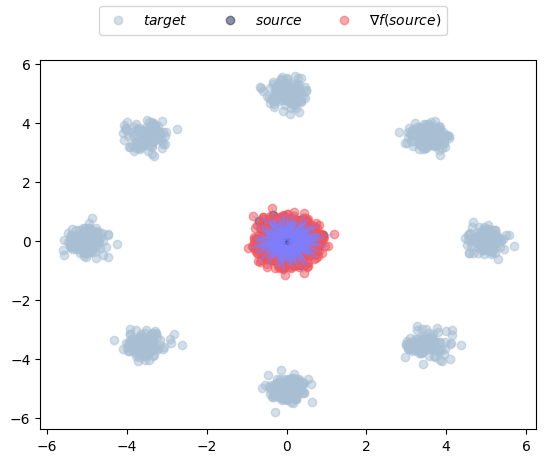

In [10]:
neuraldual.plot_ot_map(neural_dual, data_source, data_target, inverse=False)

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

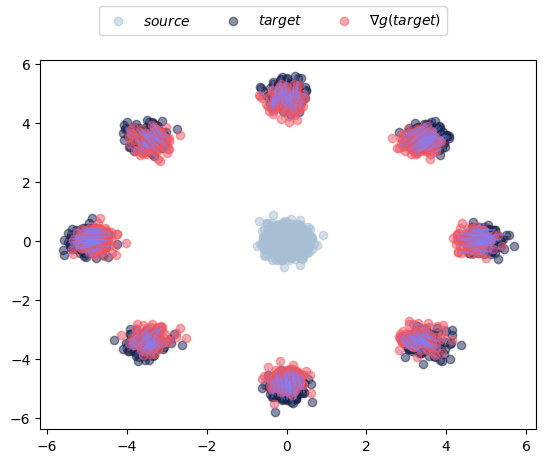

In [11]:
neuraldual.plot_ot_map(neural_dual, data_target, data_source, inverse=True)

Before training, the `identity` initialization (`num_train_iters=0`) maps source or target sample onto itself. If source and target samples are not too dissimilar, this initialization method compared to a random vanilla weight initialization achieves a good approximation already.

### Gaussian Initialization

The `Gaussian approximation`-based initialization schemes require samples from both, source and target distributions, in order to initialize the ICNNs with linear factors and means, as detailed in {cite}`bunne:22`.

In [12]:
samples_source = jnp.concatenate(
    [next(dataloader_source).numpy() for _ in range(10)]
)
samples_target = jnp.concatenate(
    [next(dataloader_target).numpy() for _ in range(10)]
)

To use the Gaussian initialization, the samples of source and target (`samples_source` and `samples_target`) need to be passed to the {class}`~ott.solvers.nn.icnn.ICNN` definition via the `gaussian_map` argument. Note that ICNN $f$ maps source to target (`gaussian_map=(samples_source, samples_target)`), and $g$ maps target to source cells (`gaussian_map=(samples_target, samples_source)`).

In [13]:
# initialize models using Gaussian initialization
neural_f = icnn.ICNN(
    dim_hidden=[64, 64, 64, 64],
    dim_data=2,
    gaussian_map=(samples_source, samples_target),
)
neural_g = icnn.ICNN(
    dim_hidden=[64, 64, 64, 64],
    dim_data=2,
    gaussian_map=(samples_target, samples_source),
)

In [14]:
neural_dual_solver = neuraldual.W2NeuralDual(
    input_dim, neural_f, neural_g, optimizer_f, optimizer_g, num_train_iters=0
)
neural_dual = neural_dual_solver(
    dataloader_source, dataloader_target, dataloader_source, dataloader_target
)

Again, we can plot the corresponding transport from source to target using the gradient of the learning potential $f$, i.e., $\nabla f(\text{source})$, or from target to source via the gradient of the learning potential $g$, i.e., $\nabla g(\text{target})$.

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

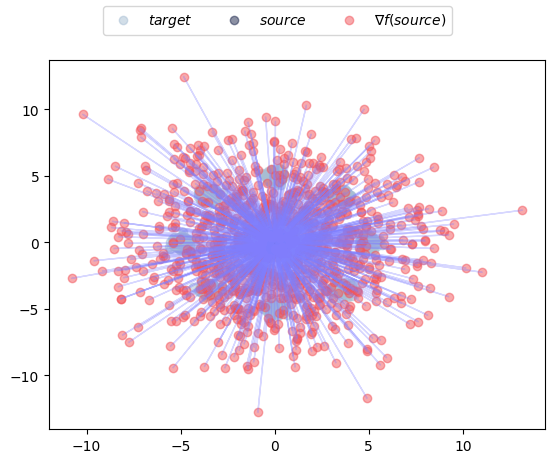

In [15]:
neuraldual.plot_ot_map(neural_dual, data_source, data_target, inverse=False)

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

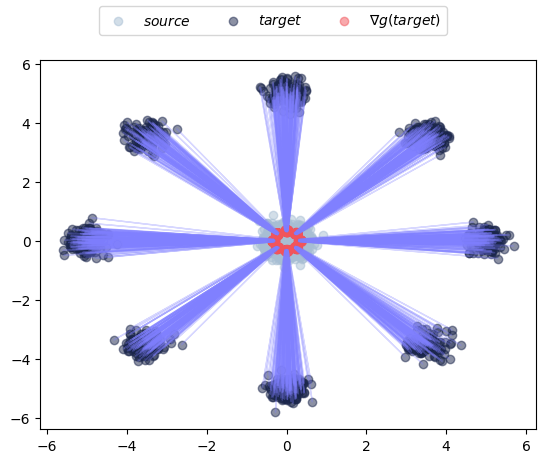

In [16]:
neuraldual.plot_ot_map(neural_dual, data_target, data_source, inverse=True)

Using this initialization scheme maps the source (using $f$) or target measure (using $g$) to the Gaussian approximation of the respective counterpart. In the case of target $\nu$ this represents almost the correct solution.